<a href="https://colab.research.google.com/github/HuyenNguyenHelen/INFO-5505---Machine-learning/blob/main/HuyenNguyen_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: K-means clustering
Dataset: [Amyotrophic Lateral Sclerosis (ALS)](https://)


In [73]:
# Import primary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Loading the dataset and exploratory analysis

In [74]:
# Load the dataset
data = pd.read_csv('/content/ALS_TrainingData_2223.csv')
data.head() 

,ID,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,ALSFRS_Total_range,ALT.SGPT._max,ALT.SGPT._median,ALT.SGPT._min,ALT.SGPT._range,AST.SGOT._max,AST.SGOT._median,AST.SGOT._min,AST.SGOT._range,Bicarbonate_max,Bicarbonate_median,Bicarbonate_min,Bicarbonate_range,Blood.Urea.Nitrogen..BUN._max,Blood.Urea.Nitrogen..BUN._median,Blood.Urea.Nitrogen..BUN._min,Blood.Urea.Nitrogen..BUN._range,bp_diastolic_max,bp_diastolic_median,bp_diastolic_min,bp_diastolic_range,bp_systolic_max,bp_systolic_median,bp_systolic_min,bp_systolic_range,Calcium_max,Calcium_median,Calcium_min,Calcium_range,Chloride_max,...,Hemoglobin_median,Hemoglobin_min,Hemoglobin_range,leg_max,leg_median,leg_min,leg_range,mouth_max,mouth_median,mouth_min,mouth_range,onset_delta_mean,onset_site_mean,Platelets_max,Platelets_median,Platelets_min,Potassium_max,Potassium_median,Potassium_min,Potassium_range,pulse_max,pulse_median,pulse_min,pulse_range,respiratory_max,respiratory_median,respiratory_min,respiratory_range,Sodium_max,Sodium_median,Sodium_min,Sodium_range,SubjectID,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min
0,1,65,57.0,40.5,38.0,0.066202,-0.965608,30,28.0,22,0.021164,24.0,22.0,18.0,0.020906,31,27.5,23.0,0.027875,30.0,28.0,25.0,0.017422,8.0322,7.11945,6.5718,0.005089,90,83.0,69,0.055556,160,139.0,129,0.082011,2.49500,2.220550,2.22055,0.000956,109.0,...,146.0,143.0,0.045296,8,6.5,4,0.010582,5,3.5,0,0.013228,-1023,1,172,169.0,152.0,4.5,4.25,4.0,0.001742,79,68.0,61,0.047619,4,3.0,3,0.002646,148.0,145.5,143.0,0.017422,533,8,7.0,7,0.002646,6.0,6.0,6.0
1,2,48,45.0,41.0,39.0,0.010453,-0.921717,37,33.0,21,0.028725,25.0,13.0,8.0,0.029617,31,17.0,14.0,0.029617,32.0,28.0,25.0,0.012195,8.3973,4.74630,4.0161,0.007633,80,78.0,64,0.028725,140,132.5,104,0.064632,2.32035,2.170650,2.02095,0.000522,108.0,...,132.0,128.0,0.017422,8,7.5,3,0.008977,9,8.0,4,0.008977,-341,1,286,264.0,230.0,5.0,4.30,3.9,0.001916,90,76.0,64,0.046679,4,4.0,3,0.001795,142.0,138.0,136.0,0.010453,649,8,7.0,5,0.005386,7.0,5.0,5.0
2,3,38,50.0,47.0,45.0,0.008929,-0.914787,24,14.0,10,0.025000,25.0,20.0,14.0,0.019643,24,19.0,18.0,0.010714,35.0,29.0,24.0,0.019643,5.4765,4.38120,3.6510,0.003260,86,76.0,58,0.050000,120,110.0,90,0.053571,2.47005,2.295400,2.19560,0.000490,108.0,...,154.0,151.0,0.017857,4,3.0,2,0.003571,10,7.0,4,0.010714,-1181,1,233,213.0,167.0,4.1,4.00,3.9,0.000357,82,73.0,60,0.039286,4,4.0,4,0.000000,145.0,143.0,140.0,0.008929,1234,5,0.0,0,0.008929,6.0,5.0,5.0
3,4,63,47.0,44.0,41.0,0.012111,-0.598361,30,29.0,24,0.014963,62.0,60.0,41.0,0.052369,46,40.0,33.0,0.032419,23.0,20.0,20.0,0.007481,8.0322,8.03220,6.5718,0.003642,90,80.0,70,0.049875,150,130.0,120,0.074813,2.47005,2.345300,2.23000,0.000474,109.0,...,145.0,144.0,0.024938,4,3.5,2,0.004988,12,12.0,12,0.000000,-365,2,275,233.0,204.0,4.3,4.20,4.0,0.000748,84,72.0,68,0.039900,3,3.0,3,0.000000,143.0,139.0,138.0,0.012469,2492,5,5.0,3,0.004988,7.0,6.0,5.0
4,5,63,47.0,45.5,42.0,0.008292,-0.444039,32,27.5,20,0.020374,38.0,26.5,22.0,0.026534,35,26.5,20.0,0.024876,32.0,28.0,23.0,0.014925,5.1114,4.19865,3.6510,0.002422,100,80.0,68,0.053068,160,130.0,104,0.092869,2.42015,2.257975,2.17065,0.000414,107.0,...,146.5,138.0,0.023217,2,2.0,0,0.003396,12,12.0,12,0.000000,-1768,2,313,283.5,268.0,4.6,3.75,3.5,0.001824,101,96.0,74,0.044776,4,4.0,3,0.001698,143.0,140.0,138.0,0.008292,2956,6,4.0,1,0.008489,6.0,5.0,5.0


In [75]:
# Print feature names
print([name for name in data.columns])

['ID', 'Age_mean', 'Albumin_max', 'Albumin_median', 'Albumin_min', 'Albumin_range', 'ALSFRS_slope', 'ALSFRS_Total_max', 'ALSFRS_Total_median', 'ALSFRS_Total_min', 'ALSFRS_Total_range', 'ALT.SGPT._max', 'ALT.SGPT._median', 'ALT.SGPT._min', 'ALT.SGPT._range', 'AST.SGOT._max', 'AST.SGOT._median', 'AST.SGOT._min', 'AST.SGOT._range', 'Bicarbonate_max', 'Bicarbonate_median', 'Bicarbonate_min', 'Bicarbonate_range', 'Blood.Urea.Nitrogen..BUN._max', 'Blood.Urea.Nitrogen..BUN._median', 'Blood.Urea.Nitrogen..BUN._min', 'Blood.Urea.Nitrogen..BUN._range', 'bp_diastolic_max', 'bp_diastolic_median', 'bp_diastolic_min', 'bp_diastolic_range', 'bp_systolic_max', 'bp_systolic_median', 'bp_systolic_min', 'bp_systolic_range', 'Calcium_max', 'Calcium_median', 'Calcium_min', 'Calcium_range', 'Chloride_max', 'Chloride_median', 'Chloride_min', 'Chloride_range', 'Creatinine_max', 'Creatinine_median', 'Creatinine_min', 'Creatinine_range', 'Gender_mean', 'Glucose_max', 'Glucose_median', 'Glucose_min', 'Glucose_ra

In [76]:
# Explore the dataset
data.describe()

,ID,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,ALSFRS_Total_range,ALT.SGPT._max,ALT.SGPT._median,ALT.SGPT._min,ALT.SGPT._range,AST.SGOT._max,AST.SGOT._median,AST.SGOT._min,AST.SGOT._range,Bicarbonate_max,Bicarbonate_median,Bicarbonate_min,Bicarbonate_range,Blood.Urea.Nitrogen..BUN._max,Blood.Urea.Nitrogen..BUN._median,Blood.Urea.Nitrogen..BUN._min,Blood.Urea.Nitrogen..BUN._range,bp_diastolic_max,bp_diastolic_median,bp_diastolic_min,bp_diastolic_range,bp_systolic_max,bp_systolic_median,bp_systolic_min,bp_systolic_range,Calcium_max,Calcium_median,Calcium_min,Calcium_range,Chloride_max,...,Hemoglobin_median,Hemoglobin_min,Hemoglobin_range,leg_max,leg_median,leg_min,leg_range,mouth_max,mouth_median,mouth_min,mouth_range,onset_delta_mean,onset_site_mean,Platelets_max,Platelets_median,Platelets_min,Potassium_max,Potassium_median,Potassium_min,Potassium_range,pulse_max,pulse_median,pulse_min,pulse_range,respiratory_max,respiratory_median,respiratory_min,respiratory_range,Sodium_max,Sodium_median,Sodium_min,Sodium_range,SubjectID,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min
count,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,...,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000
mean,1214.874944,54.550157,47.011134,43.952542,40.766347,0.013779,-0.728274,31.692308,27.104926,19.877193,0.026035,54.436257,32.993252,23.014800,0.071137,43.127755,29.076923,21.542465,0.049191,30.897301,26.963765,23.164327,0.016868,7.353054,5.558011,4.160875,0.007133,92.030589,81.113360,69.890688,0.047658,147.135403,129.579172,113.429600,0.071178,2.474835,2.345584,2.222855,0.000541,107.152182,...,144.289024,135.461130,0.038242,5.309942,4.049708,2.493477,0.006163,10.743140,9.703329,7.778228,0.006595,-682.995502,1.800720,285.301844,238.781601,208.382005,4.628367,4.189269,3.857323,0.001744,90.642375,76.973234,65.373819,0.053587,3.910031,3.592668,2.791273,0.002513,143.428880,140.145254,136.755061,0.015000,498880.290148,6.203779,4.893387,2.955915,0.007136,6.820450,5.710639,5.183221
std,696.678300,11.396546,3.233980,2.654804,3.193087,0.009567,0.622329,5.314228,6.633643,8.583509,0.016156,44.829577,15.601925,11.231221,0.110889,35.288701,9.593911,7.395303,0.084100,3.164472,2.198824,2.408519,0.011280,2.319538,1.335236,1.354256,0.005070,8.758227,7.245578,8.443662,0.027282,15.754048,12.160938,11.195037,0.033110,0.180246,0.088418,0.172787,0.000481,2.616967,...,11.602846,14.890612,0.035134,2.244651,2.280781,2.124570,0.004372,1.897501,2.771850,3.740073,0.006128,411.800405,0.419334,70.175312,52.626504,49.321238,1.325412,0.243075,0.263050,0.002898,11.104866,8.437749,7.763446,0.027403,0.298516,0.612385,1.055428,0.002477,2.333157,1.789886,2.715247,0.009283,289923.528450,1.747660,2.146076,2.358095,0.004503,0.932141,0.625039,0.437222
min,1.000000,18.000000,37.000000,34.500000,24.000000,0.000000,-4.345238,11.000000,2.500000,0.000000,0.000000,10.000000,8.000000,1.600000,0.002747,11.000000,9.000000,1.000000,0.000000,20.000000,19.500000,2.500000,0.000000,2.920800,2.190600,0.584160,0.000000,70.000000,56.000000,20.

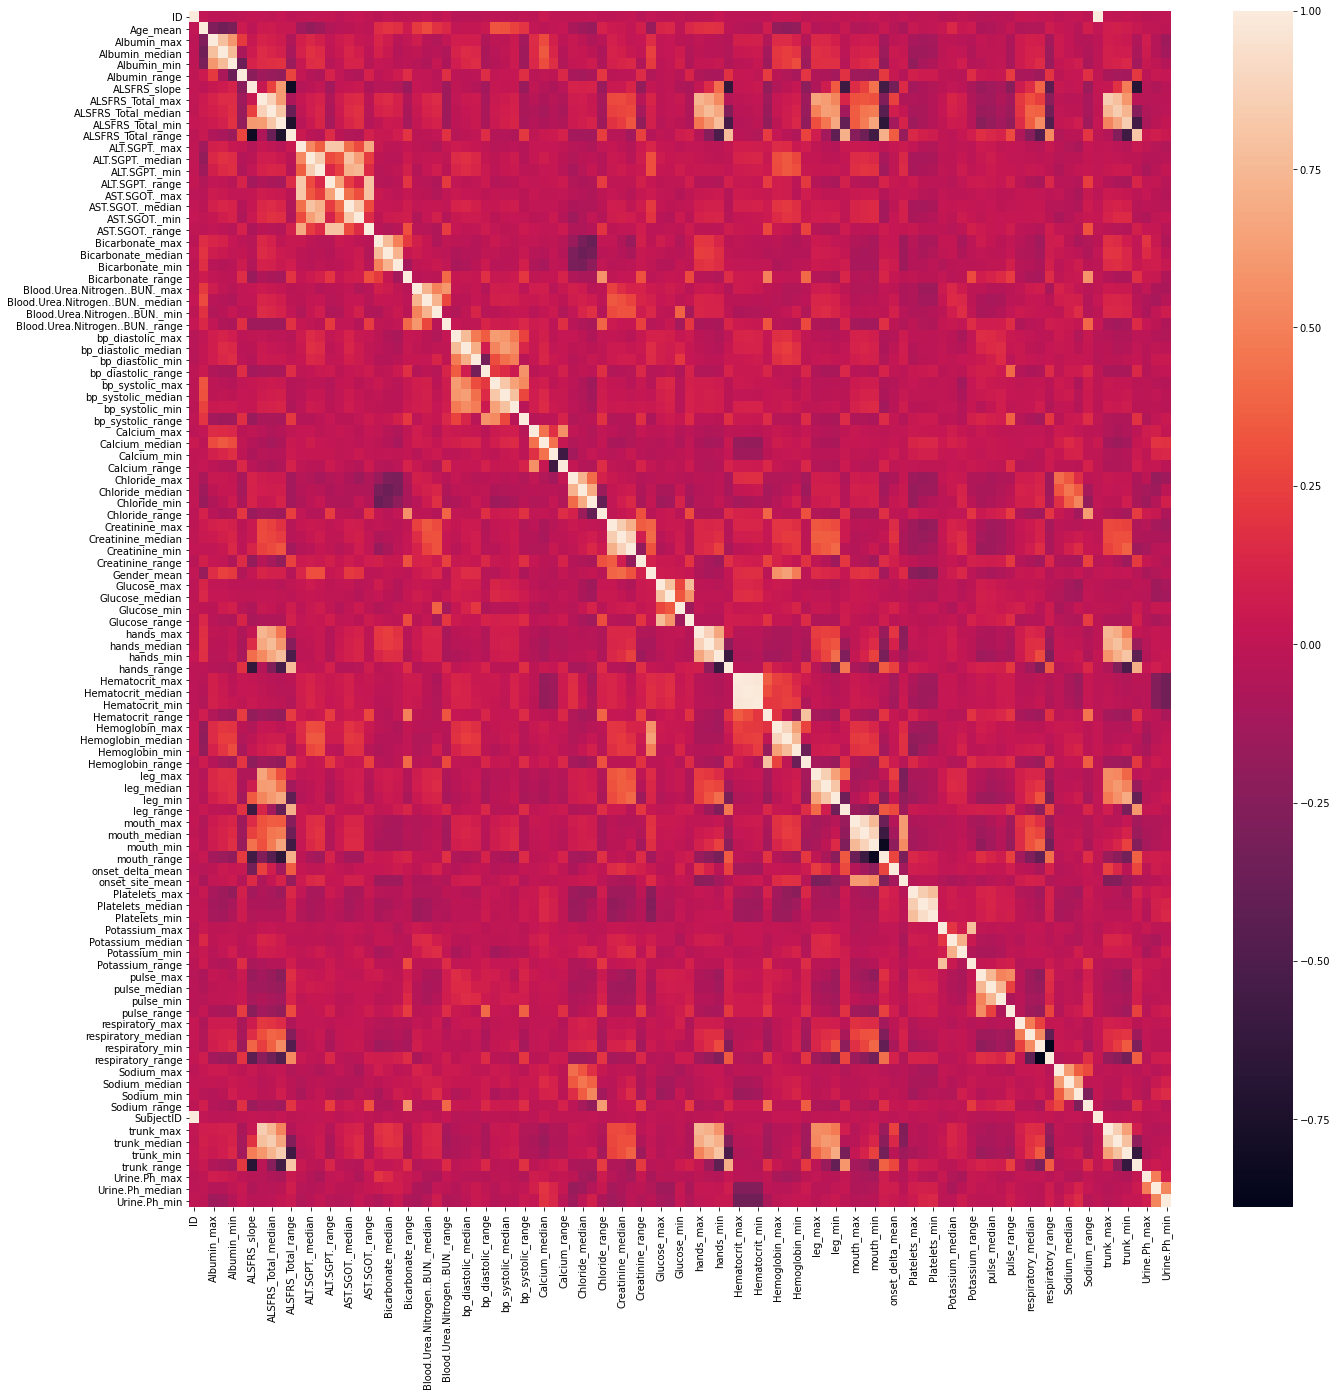

In [77]:
# Plot a heatmap with correlation score
plt.subplots(figsize=(22,22))
sns.heatmap(data.corr(), annot=False)

### Selecting variables for inputting into the k-means clustering model
The dataset has 101 columns. Inputting all of them into the model would make it very complicated, and cluster interpretation would be problematic. 

Looking at the dataset, we will drop insignificant variables such as ID. Using Principle Component Analysis (PCA) would be a good method to reduce dimensions of this dataset, but here we still can manually select variables. We can select the 'median' columns to represent for the 'min' and 'max' columns. 



In [78]:
# Drop the max and min columns
selected_variables = [c for c in data.columns if c.lower()[:-3] != 'min' or c.lower()[:-3] != 'max' or c.lower() != 'id']
print('selected variables: ', cols)

selected variables:  ['Age_mean', 'Albumin_median', 'Albumin_range', 'ALSFRS_slope', 'ALSFRS_Total_median', 'ALSFRS_Total_range', 'ALT.SGPT._median', 'ALT.SGPT._range', 'AST.SGOT._median', 'AST.SGOT._range', 'Bicarbonate_median', 'Bicarbonate_range', 'Blood.Urea.Nitrogen..BUN._median', 'Blood.Urea.Nitrogen..BUN._range', 'bp_diastolic_median', 'bp_diastolic_range', 'bp_systolic_median', 'bp_systolic_range', 'Calcium_median', 'Calcium_range', 'Chloride_median', 'Chloride_range', 'Creatinine_median', 'Creatinine_range', 'Gender_mean', 'Glucose_median', 'Glucose_range', 'hands_median', 'hands_range', 'Hematocrit_median', 'Hematocrit_range', 'Hemoglobin_median', 'Hemoglobin_range', 'leg_median', 'leg_range', 'mouth_median', 'mouth_range', 'onset_delta_mean', 'onset_site_mean', 'Platelets_median', 'Potassium_median', 'Potassium_range', 'pulse_median', 'pulse_range', 'respiratory_median', 'respiratory_range', 'Sodium_median', 'Sodium_range', 'SubjectID', 'trunk_median', 'trunk_range', 'Urine.

### Data Standardization
Looking at min, max, and standard deriviation, we see that data have different value scales/ranges. K-means clustering algorithm implements Eclidean distance to calculate distance among data points that greater values have stronger influence. For example, the weight is normally more influencial. Therefore, standardization, known as feature scaling, is an important step in k-means clustering. We will be rescaling our dataset below: 

In [79]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data= scaler.fit_transform(data)

# Turn scaled data into dataframe for convenience
scaled_data_df = pd.DataFrame(scaled_data)
scaled_data_df.columns = [c for c in data.columns]

scaled_data_df.head()

,ID,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,ALSFRS_Total_range,ALT.SGPT._max,ALT.SGPT._median,ALT.SGPT._min,ALT.SGPT._range,AST.SGOT._max,AST.SGOT._median,AST.SGOT._min,AST.SGOT._range,Bicarbonate_max,Bicarbonate_median,Bicarbonate_min,Bicarbonate_range,Blood.Urea.Nitrogen..BUN._max,Blood.Urea.Nitrogen..BUN._median,Blood.Urea.Nitrogen..BUN._min,Blood.Urea.Nitrogen..BUN._range,bp_diastolic_max,bp_diastolic_median,bp_diastolic_min,bp_diastolic_range,bp_systolic_max,bp_systolic_median,bp_systolic_min,bp_systolic_range,Calcium_max,Calcium_median,Calcium_min,Calcium_range,Chloride_max,...,Hemoglobin_median,Hemoglobin_min,Hemoglobin_range,leg_max,leg_median,leg_min,leg_range,mouth_max,mouth_median,mouth_min,mouth_range,onset_delta_mean,onset_site_mean,Platelets_max,Platelets_median,Platelets_min,Potassium_max,Potassium_median,Potassium_min,Potassium_range,pulse_max,pulse_median,pulse_min,pulse_range,respiratory_max,respiratory_median,respiratory_min,respiratory_range,Sodium_max,Sodium_median,Sodium_min,Sodium_range,SubjectID,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min
0,-1.742767,0.917137,3.089417,-1.300781,-0.866550,5.480929,-0.381450,-0.318520,0.134960,0.247368,-0.301588,-0.679085,-0.704767,-0.446606,-0.453087,-0.343750,-0.164404,0.197134,-0.253516,-0.283619,0.471374,0.762330,0.049077,0.292860,1.169674,1.780659,-0.403233,-0.231902,0.260444,-0.105510,0.289532,0.816774,0.774854,1.391144,0.327228,0.111898,-1.414439,-0.013342,0.863965,0.706250,...,0.147495,0.506397,0.200822,1.198700,1.074563,0.709255,1.011076,-3.027367,-2.238477,-2.080167,1.082677,-0.825839,-1.909933,-1.614917,-1.326277,-1.143416,-0.096872,0.249901,0.542515,-0.000570,-1.048639,-1.063702,-0.563513,-0.217842,0.301454,-0.968019,0.197810,0.053311,1.959640,2.992342,2.300470,0.260968,-1.719279,1.028018,0.981832,1.715365,-0.997420,-0.880376,0.463054,1.868532
1,-1.741331,-0.574879,-0.622016,-1.112401,-0.553303,-0.347725,-0.310907,0.998995,0.888863,0.130839,0.166537,-0.656774,-1.281749,-1.337181,-0.374515,-0.343750,-1.259094,-1.020129,-0.232796,0.348541,0.471374,0.762330,-0.414378,0.450297,-0.608052,-0.106928,0.098656,-1.373942,-0.429788,-0.697803,-0.694129,-0.453027,0.240235,-0.842491,-0.197758,-0.857276,-1.978932,-1.168779,-0.039684,0.324043,...,-1.059377,-0.501175,-0.592730,1.198700,1.513108,0.238466,0.643794,-0.918857,-0.614648,-1.010429,0.388826,0.830675,-1.909933,0.009951,0.479304,0.438409,0.280454,0.455645,0.162274,0.059556,-0.057859,-0.115369,-0.177000,-0.252168,0.301454,0.665307,0.197810,-0.289979,-0.612561,-1.198812,-0.278144,-0.489913,-1.718879,1.028018,0.981832,0.867032,-0.388669,0.192665,-1.137208,-0.419151
2,-1.739896,-1.452535,0.924415,1.148162,1.326179,-0.507103,-0.299769,-1.447819,-1.975969,-1.150976,-0.064100,-0.656774,-0.832985,-0.802836,-0.464480,-0.542158,-1.050582,-0.479123,-0.457607,1.296780,0.926265,0.347043,0.246046,-0.809203,-0.881549,-0.376583,-0.763966,-0.688718,-0.705880,-1.408555,0.085852,-1.722828,-1.610367,-2.093327,-0.531883,-0.026555,-0.567701,-0.157771,-0.105200,0.324043,...,0.837136,1.043769,-0.580331,-0.583715,-0.460344,-0.232324,-0.592848,-0.391730,-0.975499,-1.010429,0.672452,-1.209607,-1.909933,-0.745470,-0.490008,-0.839219,-0.398733,-0.778819,0.162274,-0.478576,-0.778426,-0.470994,-0.692351,-0.522019,0.301454,0.665307,1.145505,-1.014914,0.673540,1.595291,1.195350,-0.654169,-1.716861,-0.688950,-2.280669,-1.253800,0.398249,-0.880376,-1.137208,-0.419151
3,-1.738460,0.741606,-0.003443,0.017880,0.073191,-0.174361,0.208801,-0.318520,0.285741,0.480425,-0.685524,0.168760,1.731378,1.601718,-0.169287,0.081411,1.138799,1.549648,-0.199469,-2.496176,-3.167753,-1.314102,-0.832374,0.292860,1.853414,1.780659,-0.688597,-0.231902,-0.153695,0.012949,0.081281,0.181873,0.034613,0.587035,0.109797,-0.026555,-0.003208,0.041362,-0.138785,0.706250,...,0.061290,0.573569,-0.378758,-0.583715,-0.241072,-0.232324,-0.268864,0.662526,0.828

In [80]:
# Explore some basic statistics of the scaled data
scaled_data_df.describe()

,ID,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,ALSFRS_Total_range,ALT.SGPT._max,ALT.SGPT._median,ALT.SGPT._min,ALT.SGPT._range,AST.SGOT._max,AST.SGOT._median,AST.SGOT._min,AST.SGOT._range,Bicarbonate_max,Bicarbonate_median,Bicarbonate_min,Bicarbonate_range,Blood.Urea.Nitrogen..BUN._max,Blood.Urea.Nitrogen..BUN._median,Blood.Urea.Nitrogen..BUN._min,Blood.Urea.Nitrogen..BUN._range,bp_diastolic_max,bp_diastolic_median,bp_diastolic_min,bp_diastolic_range,bp_systolic_max,bp_systolic_median,bp_systolic_min,bp_systolic_range,Calcium_max,Calcium_median,Calcium_min,Calcium_range,Chloride_max,...,Hemoglobin_median,Hemoglobin_min,Hemoglobin_range,leg_max,leg_median,leg_min,leg_range,mouth_max,mouth_median,mouth_min,mouth_range,onset_delta_mean,onset_site_mean,Platelets_max,Platelets_median,Platelets_min,Potassium_max,Potassium_median,Potassium_min,Potassium_range,pulse_max,pulse_median,pulse_min,pulse_range,respiratory_max,respiratory_median,respiratory_min,respiratory_range,Sodium_max,Sodium_median,Sodium_min,Sodium_range,SubjectID,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min
count,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,...,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03
mean,-2.071617e-16,-1.760975e-16,-4.248364e-16,-5.649502e-16,-3.092943e-16,9.598959e-17,-3.236278e-17,-2.115567e-16,-9.159465e-17,3.419067e-16,2.477151e-17,-9.269338e-17,1.717774e-16,2.154022e-16,5.534884e-17,-3.961693e-17,1.598786e-17,5.951155e-16,-1.149927e-17,3.277948e-16,-5.948720e-16,1.489537e-16,-1.164660e-16,-3.104741e-16,4.426409e-16,5.633520e-17,-2.487139e-17,3.278979e-16,3.952079e-16,3.481402e-16,8.735265e-17,5.473954e-16,-9.572271e-16,-1.263547e-16,-1.644109e-16,-4.138240e-16,-1.572292e-15,1.309893e-15,-7.571292e-17,4.494356e-15,...,-5.823302e-17,7.225689e-16,7.938525e-17,1.066773e-16,1.420366e-16,8.929729e-17,3.718223e-17,6.652348e-17,-3.025520e-16,-1.391400e-16,5.933176e-17,-1.009838e-16,-1.948759e-16,2.325325e-16,1.485292e-16,1.086251e-16,2.620985e-16,2.094691e-15,2.341507e-15,9.339258e-17,-1.633122e-16,-6.867601e-16,-4.718698e-16,-1.221095e-16,-3.817609e-16,-6.910052e-16,2.274384e-16,-1.699046e-16,-5.029765e-15,-1.017575e-14,-4.276375e-15,-1.178644e-17,2.717874e-16,-2.351296e-16,2.389252e-16,1.001848e-16,1.112720e-16,1.143285e-15,9.369224e-17,-2.262398e-17
std,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,...,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.0002

It seems all variable values have the same magnitude now with a mean = 0

## Developping the K-mean clustering models


### Baselined model
For this basedlined model, we will input previous selected variables, and a k = 3 that is often selected for k-means clustering.

- Input: Selected variables: ['Age_mean', 'Albumin_median', 'Albumin_range', 'ALSFRS_slope', 'ALSFRS_Total_median', 'ALSFRS_Total_range', 'ALT.SGPT._median', 'ALT.SGPT._range', 'AST.SGOT._median', 'AST.SGOT._range', 'Bicarbonate_median', 'Bicarbonate_range', 'Blood.Urea.Nitrogen..BUN._median', 'Blood.Urea.Nitrogen..BUN._range', 'bp_diastolic_median', 'bp_diastolic_range', 'bp_systolic_median', 'bp_systolic_range', 'Calcium_median', 'Calcium_range', 'Chloride_median', 'Chloride_range', 'Creatinine_median', 'Creatinine_range', 'Gender_mean', 'Glucose_median', 'Glucose_range', 'hands_median', 'hands_range', 'Hematocrit_median', 'Hematocrit_range', 'Hemoglobin_median', 'Hemoglobin_range', 'leg_median', 'leg_range', 'mouth_median', 'mouth_range', 'onset_delta_mean', 'onset_site_mean', 'Platelets_median', 'Potassium_median', 'Potassium_range', 'pulse_median', 'pulse_range', 'respiratory_median', 'respiratory_range', 'Sodium_median', 'Sodium_range', 'SubjectID', 'trunk_median', 'trunk_range', 'Urine.Ph_median']

- k=3


In [81]:
# Import k-mean clustering package from sklearn
from sklearn.cluster import KMeans

# Setting parameters for the k-means model by a dictionary unpacking operator 
kmeans_para= {'init':'k-means++', # set k-means++ initial seed
              'n_init': 10,
              'max_iter':  300, # the number of maximum iterations for each initialization
              'random_state': 42 # make sure we got the same set of pseudo random number each time we run.
              } 

# Build a k-means clustering model
kmeans_base = KMeans (n_clusters = 3, **kmeans_para)
 
# Fit the model into scaled data that we selected variables for input
kmeans_base.fit(scaled_data_df[selected_variables])

# Print SSE of the model:
print('SSE of the based model: ', kmeans_base.inertia_)

SSE of the based model:  200403.86490022112


SSE (sum squared error) is the sum of the squared differences between each observation and mean of the cluster that it was assigned to belong. Our SSE of the based model is too high. Increasing the number of clusters will reduce this SSE. However, it may not improve SSE much, because we do not expect to have too many clusters. That would be hard to interprete the formed clusters.Therefore, we can think about reducing some more variables. 

Our aim in this assignment is to address the question: *"What patient phenotypes can be automatically and reliably identified and used to predict the change of the ALSFRS slope over time?"* We can investigate how other variable correlated with the ALSFRS slope.

In [82]:
# Caculate correlation score of other variables toward the ALSFRS_slope
cor = pd.DataFrame(data.corrwith(data['ALSFRS_slope']), columns = [ 'score'])
print('Variables positively correlated with ALSFRS_slope: ' )
print(cor[cor['score'] <= -0.2], '\n')
print('Variables positively correlated with ALSFRS_slope: ' )
print(cor[cor['score'] >= 0.2])

Variables positively correlated with ALSFRS_slope: 
                       score
Albumin_range      -0.226123
ALSFRS_Total_range -0.819305
hands_range        -0.632350
Hemoglobin_range   -0.209774
leg_range          -0.584507
mouth_range        -0.553194
onset_delta_mean   -0.324307
pulse_range        -0.236961
respiratory_range  -0.432878
trunk_range        -0.686407 

Variables positively correlated with ALSFRS_slope: 
                        score
ALSFRS_slope         1.000000
ALSFRS_Total_median  0.247250
ALSFRS_Total_min     0.601810
hands_min            0.424107
leg_min              0.348967
mouth_median         0.244704
mouth_min            0.435538
respiratory_min      0.380749
trunk_min            0.488530


It makes sense to input these highly correlated variables into the model. 

### Refined model
Based on the above correlation scores of others variables toward the  ALSFRS_slope, we input into the model below variables:

- Input:['Albumin_range', 'ALSFRS_Total_range', 'hands_range', 'Hemoglobin_range', 'leg_range', 'mouth_range', 'onset_delta_mean', 'pulse_range', 'respiratory_range', 'trunk_range', 'ALSFRS_Total_median', 'ALSFRS_Total_min', 'hands_min', 'leg_min','mouth_median', 'respiratory_min', 'trunk_min', 'Age_mean']

- k = 3


In [83]:
# Build a k-means clustering model
new_selected_var = ['Albumin_range', 'ALSFRS_Total_range', 'hands_range', 'Hemoglobin_range', 'leg_range', 'mouth_range', 'onset_delta_mean', 'pulse_range', 'respiratory_range', 'trunk_range', 'ALSFRS_Total_median', 'ALSFRS_Total_min', 'hands_min', 'leg_min','mouth_median', 'respiratory_min', 'trunk_min', 'Age_mean']
kmeans_refined = KMeans (n_clusters = 3, **kmeans_para)
 
# Fit the model into data
kmeans_refined.fit(scaled_data_df[new_selected_var])

# Print SSE of the model:
print('SSE of the refined model: ', kmeans_refined.inertia_)

SSE of the refined model:  26816.426479108603


We can see SSE of the refined model is very much lower than the based model's. Now we can experiment the refined models with different k to select a appropriate k that can produce a model with low SSE, high Silhoutte, and balanced cluster sizes, and high interpretability. 

## Selecting an appropriate number of clusters
With k-means clustering algorithm, selecting a proper numer of clusters k is problematic. The selected k should be able to minimize the variability, ditances among elements within clusters (SSE), but maximize the dissimility, distances among clusters. 

Two common methods to select a proper k are the elbow method, and the silhouette coefficient. Since none of them are better, but they should be used together to strengthen our decision. So here, we are going to find an appropriate k with both methods.

### Selecting k by applying the elbow method

In [86]:
# Build and run a series of k-mean models over a range of k

sse=[]
for k in range (1,11):
  # build k-means models
  kmeans_k= KMeans (n_clusters = k, **kmeans_para)
  # fit the model into the data
  kmeans_k.fit(scaled_data[new_selected_var])
  # append the lowest sse value for each k assignment
  sse.append (kmeans_k.inertia_)

In [87]:
print (sse)

[224523.0, 207788.85417228265, 200403.86490022112, 194509.68344209983, 190006.5677766317, 185022.06388898077, 181564.74492199856, 178444.29871453132, 174933.42495669622, 172304.3875315342]


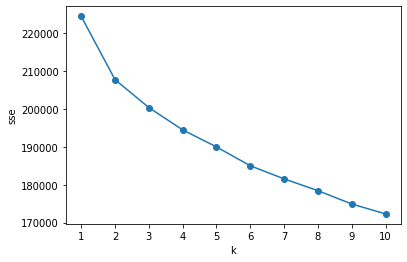

In [88]:
# Visualize the elbow of sse
x=[i for i in range (1,11)]
y=sse
plt.plot(x, y, marker='o')
plt.xticks(x)
plt.xlabel('k')
plt.ylabel('sse')
plt.show()

Looking at the elbow plot, we can select a k = 2, k=3, or k=4.

Let see their Silhouette coefficients

### Silhouette coefficient 
This method measures the cohesion within clusters and disimilarity between cluster. This score ranges from -1 to 1. The greater the score is, the better the model performs. 

In [52]:
# Build and run a series of k-mean models over a range of k to get the Silhoutte coefficient

# import the library
from sklearn.metrics import silhouette_score

sil_cof=[]
for k in range (2,11):
  # build k-means models
  kmeans_refined = KMeans (n_clusters = k, **kmeans_para)
  # fit the model into the data
  kmeans_refined.fit(scaled_data)
  # get Silhouette coefficient score
  sil_cof_score = silhouette_score(scaled_data,kmeans.labels_ )
  # append the silhouette score for each k assignment
  sil_cof.append (sil_cof_score)

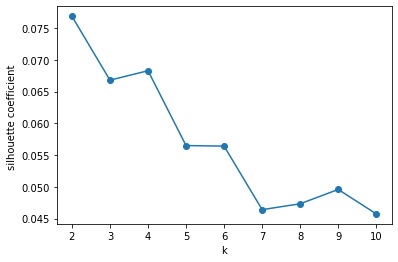

In [53]:
# Visualize the silhoutte efficient for each k
x=[i for i in range (2,11)]
y=sil_cof
plt.plot(x, y, marker='o')
plt.xticks(x)
plt.xlabel('k')
plt.ylabel('silhouette coefficient ')
plt.show()

The highest silhouette scores are for k=2, k=3, and k=4. However, two clusers are often too few because its clusters would be too general. It seems k=3 is the optimum for the two validation methods.

## K-means Cluster Model with k=4

In [54]:

kmeans_k3 = KMeans (n_clusters = 4, **kmeans_para)
# fit the model into the scaled selected feature values
kmeans_k3.fit(scaled_data)
# print the SSE of the model
print ('SSE:', kmeans_k3.inertia_)

# apply the model to cluster the dataset
pred = kmeans_k3.predict(scaled_data)

SSE: 194509.68344209983


In [56]:
# Observe the data sizes of formed clusters
scaled_data_df = pd.DataFrame(scaled_data)
#scaled_data_df.columns = ['Age_mean', 'Albumin_median', 'ALSFRS_slope', 'ALSFRS_Total_median', 'ALT.SGPT._median', 'AST.SGOT._median', 'Bicarbonate_median', 'Blood.Urea.Nitrogen..BUN._median', 'bp_diastolic_median', 'bp_systolic_median', 'Calcium_median', 'Chloride_median', 'Creatinine_median', 'Gender_mean', 'Glucose_median', 'hands_median', 'Hematocrit_median', 'Hemoglobin_median', 'leg_median', 'mouth_median', 'onset_delta_mean', 'onset_site_mean', 'Platelets_median','Potassium_median', 'pulse_median', 'respiratory_median', 'Sodium_median', 'SubjectID', 'trunk_median', 'Urine.Ph_median']

scaled_data_df['cluster'] = pred
scaled_data_df['cluster'].value_counts()

0    900
1    682
3    461
2    180
Name: cluster, dtype: int64

We can see data sizes of three clusters are quite balanced. This is what we aimed to achieve.

## Cluster Interpretation
Interpretability is especially important for k-means clustering, and unsupervised machine learning in general.

It's better to use original data for interpreting rather than standardized data.

In [57]:

data['cluster']=pred

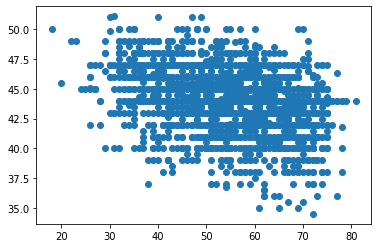

In [ ]:
# Select several significant variables for plotting with centriod of clusters
plt.scatter(  data['Age_mean'], data['Albumin_median'])
#plt.scatter(data["x2"], data["y"])
plt.show()

X=['Age_mean', 'Albumin_median', 'ALSFRS_slope', 'ALSFRS_Total_median', 'ALT.SGPT._median', 'AST.SGOT._median', 'Bicarbonate_median', 'Blood.Urea.Nitrogen..BUN._median', 'bp_diastolic_median', 'bp_systolic_median', 'Calcium_median', 'Chloride_median', 'Creatinine_median', 'Gender_mean', 'Glucose_median', 'hands_median', 'Hematocrit_median', 'Hemoglobin_median', 'leg_median', 'mouth_median', 'onset_delta_mean', 'onset_site_mean', 'Platelets_median','Potassium_median', 'pulse_median', 'respiratory_median', 'Sodium_median', 'SubjectID', 'trunk_median', 'Urine.Ph_median']

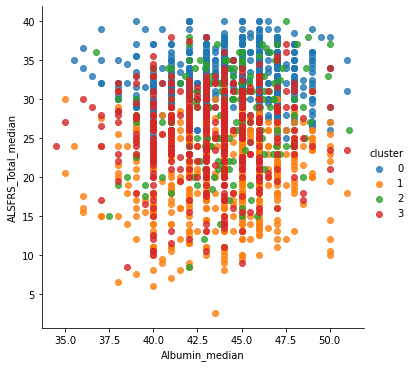

In [58]:
sns.lmplot(x='Albumin_median', y='ALSFRS_Total_median', data=data, hue='cluster', fit_reg=False)


AttributeError: ignored

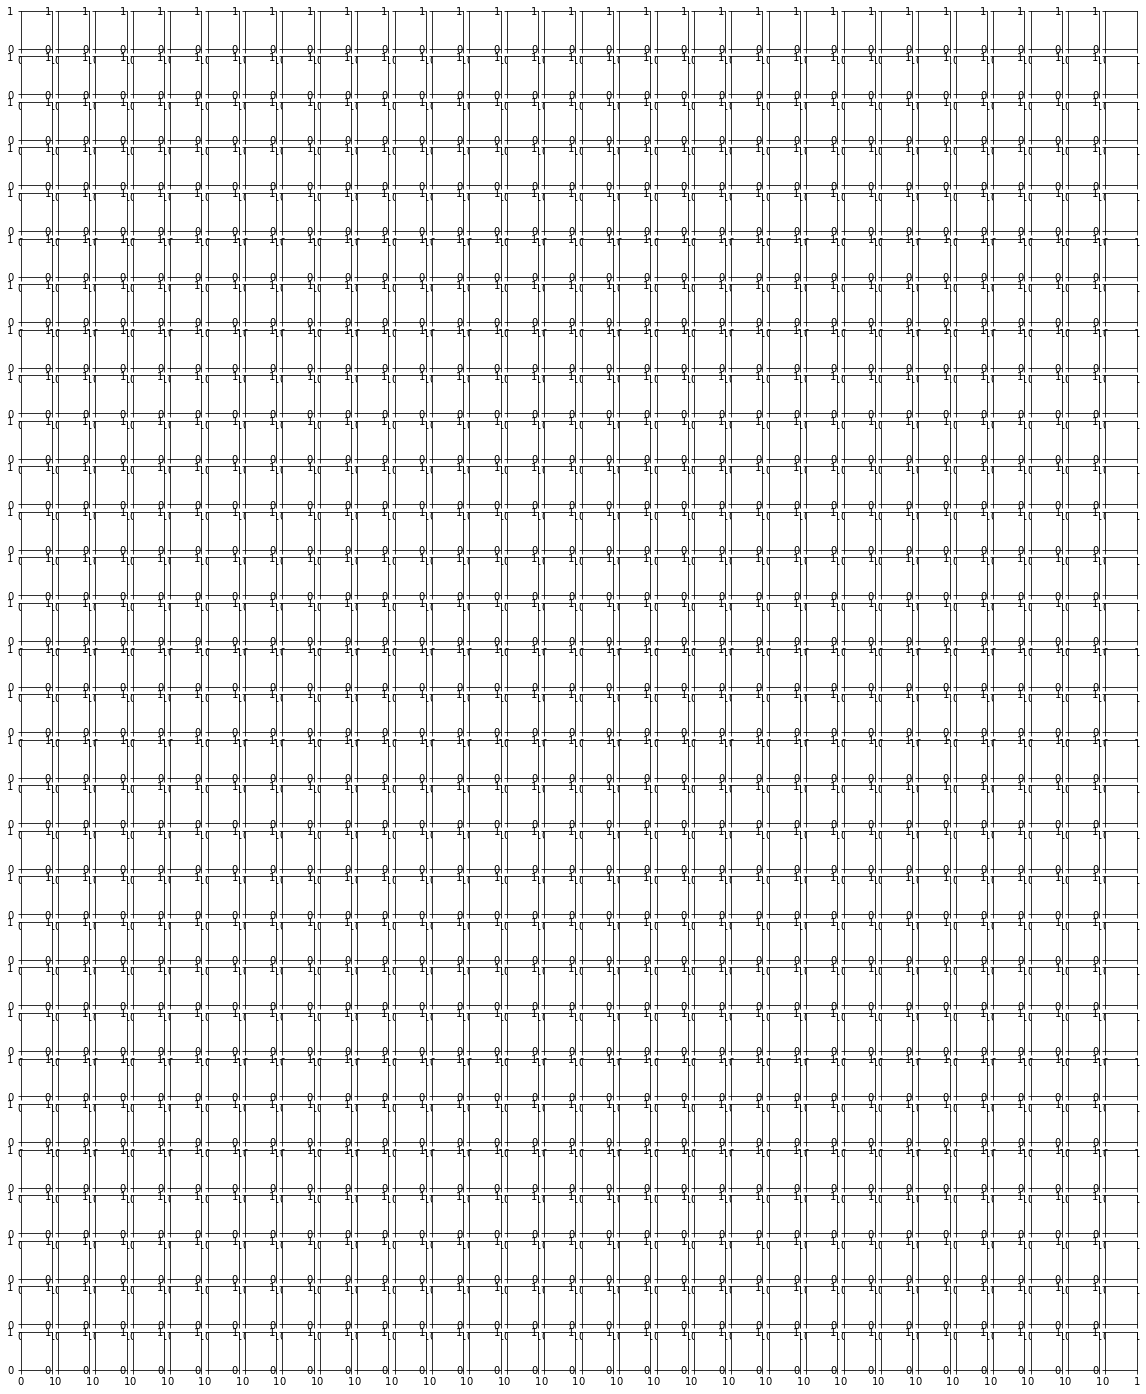

In [ ]:
Y=['Age_mean', 'Albumin_median', 'ALSFRS_Total_median', 'ALT.SGPT._median', 'AST.SGOT._median', 'Bicarbonate_median', 'Blood.Urea.Nitrogen..BUN._median', 'bp_diastolic_median', 'bp_systolic_median', 'Calcium_median', 'Chloride_median', 'Creatinine_median', 'Gender_mean', 'Glucose_median', 'hands_median', 'Hematocrit_median', 'Hemoglobin_median', 'leg_median', 'mouth_median', 'onset_delta_mean', 'onset_site_mean', 'Platelets_median','Potassium_median', 'pulse_median', 'respiratory_median', 'Sodium_median', 'SubjectID', 'trunk_median', 'Urine.Ph_median']
f, axes = plt.subplots(30, 30, figsize=(20, 25), sharex=False)
for y in Y:
  axes.sns.lmplot(x='ALSFRS_slope',y=y, data=data, hue='cluster', fit_reg=False)


In [ ]:
selected_data = data[['Age_mean', 'Albumin_median', 'ALSFRS_slope', 'ALSFRS_Total_median', 'ALT.SGPT._median', 'AST.SGOT._median', 'Bicarbonate_median', 'Blood.Urea.Nitrogen..BUN._median', 'bp_diastolic_median', 'bp_systolic_median', 'Calcium_median', 'Chloride_median', 'Creatinine_median', 'Gender_mean', 'Glucose_median', 'hands_median', 'Hematocrit_median', 'Hemoglobin_median', 'leg_median', 'mouth_median', 'onset_delta_mean', 'onset_site_mean', 'Platelets_median','Potassium_median', 'pulse_median', 'respiratory_median', 'Sodium_median', 'SubjectID', 'trunk_median', 'Urine.Ph_median', 'cluster']]
sns.pairplot(selected_data,hue='cluster')

In [ ]:
# Load the dataset
#data = pd.read_csv('/content/ALS_TestingData_78.csv')
#data.head() 